In [7]:
import numpy as np
from scipy import special, optimize
from math import factorial as fact
import matplotlib.pyplot as plt
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from mpl_toolkits.axes_grid1 import make_axes_locatable


plt.rcParams['font.size'] = 15
plt.rcParams["axes.labelsize"] = 15

In [16]:
def k(alpha, beta, gamma):
    """normalizing constant for PSF"""
    K = beta*alpha*np.sqrt(1 - gamma*gamma) / (2*np.pi)
    return K


def integrate_lim(x,y,thetaX,thetaY,alpha, beta,a):
    """integration limits for mu_prime"""
    u1 = alpha * (x-thetaX-a/2)
    u2 = alpha * (x-thetaX+a/2)
    v1 = beta  * (y-thetaY-a/2)
    v2 = beta  * (y-thetaY+a/2)
    return u1,u2,v1,v2
   
    
def numIntegrand_muP(x,y1,y2,gamma):
    """integrand of mu_prime, integrate over x, constants y1 & y2"""
    deltaErf = special.erf((y2+x*gamma)/np.sqrt(2))-special.erf((y1+x*gamma)/np.sqrt(2)) 
    integrand = np.sqrt(np.pi/2) * np.exp(x*x*(gamma*gamma-1)/2)*deltaErf
    return integrand


def numIntegrate(x1,x2,y1,y2,gamma,numSteps,integrand):
    """numerical integration of mu_prime, integration over x"""
    x = np.linspace(x1,x2,numSteps)
    h = (x2-x1)/(numSteps-1)
    trapzSum = 0
    for i in range(len(x)):
        trapzSum += integrand(x[i],y1,y2,gamma) * h
    trapzSum = trapzSum - h/2 * (integrand(x[0],y1,y2,gamma)+integrand(x[-1],y1,y2,gamma))
    return trapzSum


def mu_prime(x,y,thetaX,thetaY,a,alpha, beta,gamma,numSteps):
    """integrate analytically and numerically"""
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,alpha, beta,a)
    mu_p = np.zeros(x.shape)
    for i in range(len(x)):
        for j in range(len(y)):
            maxVal = max([abs(val) for val in [u1[i,j],u2[i,j],v1[i,j],v2[i,j]]])
            if maxVal == abs(u1[i,j]) or maxVal == abs(u2[i,j]):
                #integrate numerically over u
                mu_p[i,j] = numIntegrate(u1[i,j],u2[i,j],v1[i,j],v2[i,j],gamma,numSteps,numIntegrand_muP)
            elif maxVal == abs(v1[i,j]) or maxVal == abs(v2[i,j]):
                mu_p[i,j] = numIntegrate(v1[i,j],v2[i,j],u1[i,j],u2[i,j],gamma,numSteps,numIntegrand_muP)
    return mu_p



def mu(x,y,thetaX,thetaY,thetaI0,a,numSteps,alpha,beta,gamma,thetabg):
    """image model for gaussian psf"""
    K = k(alpha, beta, gamma)
    mu_p = mu_prime(x,y,thetaX,thetaY,a,alpha, beta,gamma,numSteps)
    mu = thetaI0*K*mu_p/alpha/beta + thetabg*a**2
    return mu


def dmu_dthetaI0(x,y,thetaX,thetaY,a,numSteps,alpha, beta, gamma):
    """derivative of mu wrt thetaI0"""
    K = k(alpha, beta, gamma)
    mu_p = mu_prime(x,y,thetaX,thetaY,a,alpha, beta,gamma,numSteps)
    dmu_dthetaI0 = K/alpha/beta * mu_p
    return dmu_dthetaI0


def dmu_dthetabg(a):
    """derivative of mu wrt thetabg"""
    d = a**2
    return d


def dErf(x,y1,y2, gamma):
    """delta error functions for thetaX, thetaY derivatives"""
    deltaErf = special.erf((y1+x*gamma)/np.sqrt(2))-special.erf((y2+x*gamma)/np.sqrt(2)) 
    return deltaErf


def dmu_dthetaX(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0):
    """derivative of mu wrt thetaX"""
    K = k(alpha, beta, gamma)/alpha/beta
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,alpha, beta,a)
    derf_u1 = dErf(u1,v2,v1, gamma)
    derf_u2 = dErf(u2,v2,v1, gamma)
    bracket = np.exp(u2*u2*(gamma*gamma-1)/2)*derf_u2 - np.exp(u1*u1*(gamma*gamma-1)/2)*derf_u1
    dmu_dthetaX = thetaI0*K*(-alpha)*np.sqrt(np.pi/2)*bracket
    return dmu_dthetaX


def dmu_dthetaY(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0):
    """derivative of mu wrt thetaY"""
    K = k(alpha, beta, gamma)/alpha/beta
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,alpha, beta, a)
    derf_v1 = dErf(v1,u2,u1, gamma)
    derf_v2 = dErf(v2,u2,u1, gamma)
    bracket = np.exp(v2*v2*(gamma*gamma-1)/2)*derf_v2 - np.exp(v1*v1*(gamma*gamma-1)/2)*derf_v1
    dmu_dthetaY = thetaI0*K*(-beta)*np.sqrt(np.pi/2)*bracket
    return dmu_dthetaY


def dK(alpha, beta, gamma, dAlpha=False, dBeta=False, dGamma=False):
    """derivatives of K wrt alpha, beta, gamma"""
    if dAlpha:
        dK = beta*np.sqrt(1-gamma*gamma)/(2*np.pi)
    elif dBeta: 
        dK = alpha*np.sqrt(1-gamma*gamma)/(2*np.pi)
    elif dGamma:
        dK = -alpha*beta*gamma/(2*np.pi*np.sqrt(1-gamma*gamma))
    return dK


def dmu_dalpha(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0, numSteps):
    """derivative of image model wrt alpha"""
    K = k(alpha, beta, gamma)
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,alpha, beta, a)
    derf_u1 = dErf(u1,v2,v1, gamma)
    derf_u2 = dErf(u2,v2,v1, gamma)
    mu_p = mu_prime(x,y,thetaX,thetaY,a,alpha, beta,gamma,numSteps)
    bracket = np.exp(u2*u2*(gamma*gamma-1)/2)*derf_u2*(x-thetaX+a/2)- np.exp(u1*u1*(gamma*gamma-1)/2)*derf_u1*(x-thetaX-a/2) 
    dK_dalpha = dK(alpha, beta, gamma, dAlpha=True)
    dmuP_dalpha = np.sqrt(np.pi/2)*bracket
    dmu_dalpha = -thetaI0/beta * (dK_dalpha*mu_p/alpha - K*mu_p/alpha**2 + K/alpha*dmuP_dalpha)
    return dmu_dalpha


def dmu_dbeta(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps):
    """derivative of image model wrt beta"""
    K = k(alpha, beta, gamma)
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,alpha, beta,a)
    derf_v1 = dErf(v1,u2,u1, gamma)
    derf_v2 = dErf(v2,u2,u1, gamma)
    mu_p = mu_prime(x,y,thetaX,thetaY,a,alpha, beta,gamma,numSteps)
    bracket = np.exp(v2*v2*(gamma*gamma-1)/2)*derf_v2*(y-thetaY+a/2) - np.exp(v1*v1*(gamma*gamma-1)/2)*derf_v1*(y-thetaY-a/2)
    dK_dbeta = dK(alpha, beta, gamma, dBeta=True)
    dmuP_dbeta = np.sqrt(np.pi/2)*bracket
    dmu_dbeta = -thetaI0/alpha * (dK_dbeta*mu_p/beta - K*mu_p/beta**2 + K/beta*dmuP_dbeta)
    return dmu_dbeta


def dmuPrime_dGamma_integrand(x,y1,y2,gamma):
    """derivative of mu_prime wrt gamma integrand"""
    #integrate over x
    brac1 = 2+np.exp((y1+x*gamma)**2/2)*np.sqrt(2*np.pi)*x*gamma*special.erf((y1+x*gamma)/np.sqrt(2))
    brac2 = 2+np.exp((y2+x*gamma)**2/2)*np.sqrt(2*np.pi)*x*gamma*special.erf((y2+x*gamma)/np.sqrt(2))
    p1 = np.exp(-y1**2/2-0.5*x*(x+2*y1*gamma))*brac1
    p2 = np.exp(-y2**2/2-0.5*x*(x+2*y2*gamma))*brac2
    integrand = 0.5*x*(p2-p1)
    return integrand


def dmuPrime_dGamma(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps):
    """derivative of mu_prime wrt gamma"""
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,alpha, beta, a)
    dmuPrime_dGamma = np.zeros(x.shape)
    for i in range(len(x)):
        for j in range(len(y)):
            maxVal = max([abs(i) for i in [u1[i,j],u2[i,j],v1[i,j],v2[i,j]]])
            if maxVal == abs(u1[i,j]) or maxVal == abs(u2[i,j]):
                #integrate numerically over u
                dmuPrime_dGamma[i,j] = numIntegrate(u1[i,j],u2[i,j],v1[i,j],v2[i,j],gamma,numSteps,dmuPrime_dGamma_integrand)
            elif maxVal == abs(v1[i,j]) or maxVal == abs(v2[i,j]):
                dmuPrime_dGamma[i,j] =  numIntegrate(v1[i,j],v2[i,j],u1[i,j],u2[i,j],gamma,numSteps,dmuPrime_dGamma_integrand)
    return dmuPrime_dGamma


def dmu_dgamma(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps):
    """derivative of image model wrt gamma"""
    K = k(alpha, beta, gamma)
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,alpha, beta, a)
    dK_dgamma = dK(alpha, beta, gamma, dGamma=True)
    mu_p = mu_prime(x,y,thetaX,thetaY,a,alpha, beta,gamma,numSteps)
    dmuP_dgamma = dmuPrime_dGamma(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps)
    dmu_dgamma = thetaI0/alpha/beta * (K*dmuP_dgamma + dK_dgamma*mu_p)
    return dmu_dgamma


def takeDer(para,x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps):
    """take derivatives options"""
    if para == "thetaX":
        der = dmu_dthetaX(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0)
    elif para == "thetaY":
        der = dmu_dthetaY(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0)
    elif para == "thetaI0":
        der = dmu_dthetaI0(x,y,thetaX,thetaY,a,numSteps,alpha, beta, gamma)
    elif para == "thetabg":
        der = dmu_dthetabg(a)
    elif para == "alpha":
        der = dmu_dalpha(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0, numSteps)
    elif para == "beta":
        der = dmu_dbeta(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps)
    elif para == "gamma":
        der = dmu_dgamma(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps)
    return der


def fisher(xmax, ymax, thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps,thetabg):
    """calculate fisher matrix"""
    para = ["thetaX", "thetaY", "thetaI0","thetabg", "alpha", "beta","gamma"]
    n = len(para)
    fisher = np.zeros((n,n))
    
    x, y = np.arange(xmax), np.arange(ymax)
    xs, ys = np.meshgrid(x,y)
    ys = np.flipud(ys)
    mus = mu(xs,ys,thetaX,thetaY,thetaI0,a,numSteps,alpha,beta,gamma,thetabg) 
    
    for i in range(n):
        for j in range(n):
            fisher[i,j] = np.sum(1/mus * takeDer(para[i],xs,ys,thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps) * \
                                 takeDer(para[j],xs,ys,thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps))
    return fisher


def crlb(xmax, ymax, thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps,thetabg):
    """inverse fisher, retrieve CRLBs"""
    fisherM = fisher(xmax, ymax, thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps,thetabg)
    fisherInv = np.linalg.inv(fisherM)
    crlbs = [fisherInv[i,i] for i in range(len(fisherM))]
    print("#",end="")
    return crlbs


def para(a,b,theta):
    alpha = np.sqrt(a**2*np.cos(theta)**2 + b**2*np.sin(theta)**2)
    beta  = np.sqrt(b**2*np.cos(theta)**2 + a**2*np.sin(theta)**2)
    gamma = np.sin(2*theta)*(a**2-b**2)/(2*alpha*beta)
    return alpha,beta,gamma

# test 1 bound for 2 images

In [17]:
theta1, theta2 = 0,0
width1 = 2
height1 = 2

alpha1,beta1,gamma1 = para(1/width1,1/height1,theta1)

xmax = 3*8
ymax = xmax
X = (xmax-1)/2
Y = X
X1 = X
Y1 = Y
a = 0.2
thetabg = 1e-5
numSteps = 30
I1 = 500

crlb(xmax, ymax, X, Y,a,alpha1,beta1,gamma1,I1,numSteps,thetabg)

#

[0.20017787278046176,
 0.20017787278046173,
 12500.241066273751,
 1.183744314174792e-06,
 0.006264243770429598,
 0.006264243770429597,
 0.050096819254618584]

# test photon counts

In [4]:
theta = np.pi/4
n = 20
width = 3
height = 2
alpha,beta,gamma = para(width, height,theta)
xmax = 3*8
ymax = xmax
thetaX = (xmax-1)/2
thetaY = thetaX
N=500
a = 0.5 
thetabg = 1
numSteps = 100
x,y = np.arange(xmax), np.arange(ymax)
xs, ys = np.meshgrid(x,y)
pixelsize = np.arange(0.2,1,0.05)
u1,u2,v1,v2 = integrate_lim(xs,ys,thetaX,thetaY,a)
m = [np.sum(mu(xs,ys,thetaX,thetaY,N,pixelsize[i],numSteps,1/alpha,1/beta,gamma,thetabg)) for i in range(len(pixelsize))]
mT = pixelsize**2*thetabg*xmax**2 + N*pixelsize**2

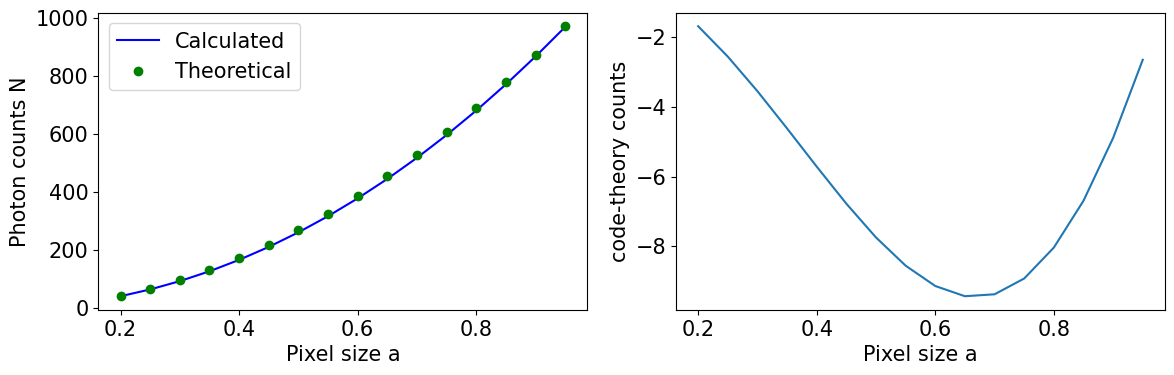

In [5]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(pixelsize,m,"b", label="Calculated")
ax[0].plot(pixelsize,mT,"go", label="Theoretical")
ax[0].set_xlabel("Pixel size a")
ax[0].set_ylabel("Photon counts N")
ax[0].legend()

ax[1].plot(pixelsize, m-mT)
ax[1].set_xlabel("Pixel size a")
ax[1].set_ylabel("code-theory counts")
fig.tight_layout()

# test image rotation

photon count code: 43.0399
photon count true: 43.0400
alpha=0.42, beta=0.42, gamma=-0.38, xmax=24, a=0.2, bg=1, rotation=0.25Pi


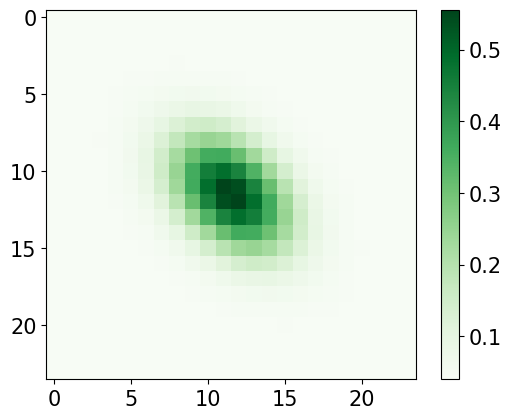

In [9]:
theta = np.pi/4
n = 20
width = 3
height = 2
alpha,beta,gamma = para(1/width,1/height,theta)
xmax = 3*8
ymax = xmax
thetaX = (xmax-1)/2
thetaY = thetaX
a = 0.2
thetabg = 1
numSteps = 30


N = 500
x,y = np.arange(xmax), np.arange(ymax)
xs, ys = np.meshgrid(x,y)
m = mu(xs, ys, thetaX, thetaY, N,a,numSteps,alpha,beta,gamma,thetabg)
plt.imshow(m,cmap="Greens")
plt.colorbar();

print(f'photon count code: {np.sum(m):.4f}')
print(f'photon count true: {a**2*thetabg*xmax**2+N*a**2:.4f}')
print(f"alpha={alpha:.2f}, beta={beta:.2f}, gamma={gamma:.2f}, xmax={xmax}, a={a}, bg={thetabg}, rotation={theta/np.pi}Pi")

# test bounds

In [10]:
#ROTATED
theta = np.pi/4*0
n = 20
alpha0 = 2
beta0 = 2
alpha,beta,gamma = para(1/alpha0,1/beta0,theta)
xmax = 3*8
ymax = xmax
thetaX = (xmax-1)/2
thetaY = thetaX
a = 0.2
thetabg =  1e-5
numSteps = 30
N = 500

x,y = np.arange(xmax), np.arange(ymax)
xs, ys = np.meshgrid(x,y)

crlb(xmax, ymax, thetaX,thetaY,a,alpha,beta,gamma,N,numSteps,thetabg)

#

[0.20017787278046176,
 0.20017787278046173,
 12500.241066273751,
 1.183744314174792e-06,
 0.006264243770429598,
 0.006264243770429597,
 0.050096819254618584]

In [11]:
theta = np.pi/4*0
n = 20
width = 3
height = 2
alpha,beta,gamma = para(1/width,1/height,theta)
xmax = 3*8
ymax = xmax
thetaX = (xmax-1)/2
thetaY = thetaX
a = 0.2
thetabg =  1e-10
numSteps = 30

N = np.arange(100, 1100, 100)

crlbs = [crlb(xmax, ymax, thetaX,thetaY,a,alpha,beta,gamma,N[i],numSteps,thetabg) for i in range(len(N))]        


##########

width=3, height=2, alpha=0.3333333333333333, beta=0.5, a=0.2, bg=1e-10

for X: simulation: var(x) = 225.3246/N + -0.0000
for X: theory    : var(x) = 224.99999999999994/N + const/a^2

for Y: simulation: var(y) = 100.0894/N + -0.0000
for Y: theory    : var(y) = 99.99999999999999/N + const/a^2


/home/insepien/miniconda3/envs/desc/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


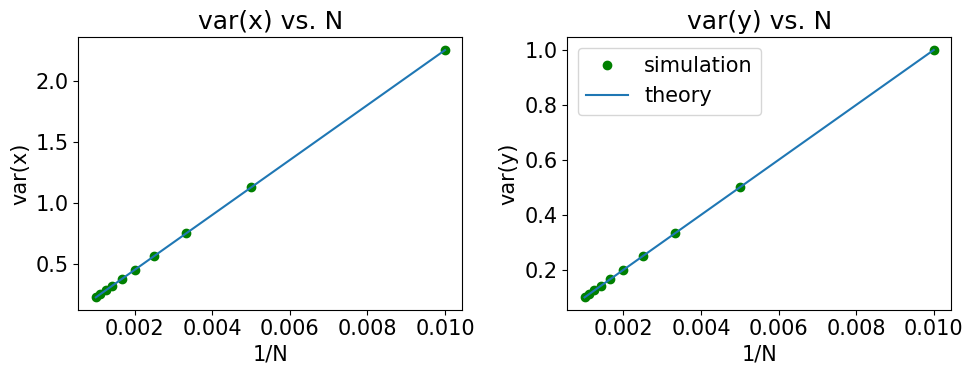

In [13]:
N = np.arange(100, 1100, 100)

def line(x,m,b):
    return m*x+b

col = ["var(x)", "var(y)", "var(N)", "var(b)", "var(alpha)","var(beta)", "var(gamma)"]
df = pd.DataFrame(crlbs, columns=col)       
varX = df["var(x)"]
varY = df["var(y)"]

poptX, pcov = optimize.curve_fit(line, 1/N, varX)
poptY, pcov = optimize.curve_fit(line, 1/N, varY)

fig,ax = plt.subplots(1,2,figsize=(10,4))

ax[0].plot(1/N,line(1/N, poptX[0], poptX[1]),"go", label="simulation")
ax[0].plot(1/N, line(1/N, width**2/a**2, 0),label="theory")
ax[0].set_xlabel("1/N")
ax[0].set_ylabel("var(x)")
ax[0].set_title("var(x) vs. N")

ax[1].plot(1/N,line(1/N, poptY[0], poptY[1]),"go", label="simulation")
ax[1].plot(1/N, line(1/N, height**2/a**2, 0),label="theory")
ax[1].set_xlabel("1/N")
ax[1].set_ylabel("var(y)")
ax[1].set_title("var(y) vs. N")
ax[1].legend()


fig.tight_layout()
;

print(f"width={width}, height={height}, alpha={alpha}, beta={beta}, a={a}, bg={thetabg}")
print()
print(f"for X: simulation: var(x) = {poptX[0]:.4f}/N + {poptX[1]:.4f}")
print(f"for X: theory    : var(x) = {(width)**2/a**2}/N + const/a^2")
print()
print(f"for Y: simulation: var(y) = {poptY[0]:.4f}/N + {poptY[1]:.4f}")
print(f"for Y: theory    : var(y) = {(height)**2/a**2}/N + const/a^2")